In [1]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
import mysql
import time
import datetime
import configparser
import pymysql
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

In [2]:
# extract the currency table's HTML code 

def extract_currency_table(url):
    content = requests.get(url).text 
    soup= BeautifulSoup(content,'lxml')
    table_content = soup.find('div', class_='table_conv')
    return table_content 

In [3]:
# extract the currency table's data

def extract_currency_data(table_content):
    data ={}
    theaders = table_content.find_all('th')
    for header in theaders:
        data[header.text]=[]
    headers= list(data.keys())

    trows = table_content.find_all('tr')
    for row in trows: 
            row_data_list = row.find_all('td')
            for index in range(len(row_data_list)):
                 data[headers[index]].append(row_data_list[index].text)
  
    return data 


In [4]:
#saving the data into a csv file
#df.to_csv(r'database.csv', index = False)

In [5]:
#insert your data base connection info 

def open_database():
    return  pymysql.connect(host='XXXXXXX',user='XXXXX',password='XXXXXXXX',db='XXXXXXXXX')

In [6]:
# creating a database table 

def create_table(db):
    cursor = db.cursor()
    sql = """ CREATE TABLE IF NOT EXISTS data (
    Désignation CHAR(60),
    Code CHAR(3),
    Unité INT,
    Achat  FLOAT, 
    Vente FLOAT, 
    Date DATE
    )
    """
    cursor.execute(sql)
    db.commit()
    cursor.close()

In [7]:
#inserting data into the table we created above 

def insert_data (db,df):
    cursor = db.cursor()
    time_stamp = datetime.datetime.now()
    Date = time_stamp.strftime("%Y-%m-%d")
    for index, row in df.iterrows():
        query = "INSERT INTO data ( Désignation, Code, Unité, Achat ,Vente, Date) VALUES (%s,%s, %s, %s, %s ,%s)"
        series= pd.Series ([Date])
        row=row.append(series)
        cursor.execute(query,tuple(row.values))
    db.commit()
    cursor.close()    

In [8]:
# change MySql-database-table info into a pandas-dataframe

def DB_to_dataframe():
    db=open_database()
    query ='select DISTINCT * from data ORDER BY Code,Date '
    dataframe = pd.read_sql(query,db)
    return dataframe 

In [9]:
#calculate the number of rows that correspond to each currency

def row_per_currency():
    Count ="select count(DISTINCT Date) from data"
    Count_df= pd.read_sql(Count,db)
    row_per_currency= Count_df.iloc[0].values
    return row_per_currency[0]

In [10]:
#plotting currencies' values 

def animate(dataframe,Code_index,nb_rows):
    
    df= dataframe.iloc[Code_index:nb_rows,]
    title = df.Code[Code_index]
    
    xs = df.iloc[0:,5].values
    Achat_ys = df.iloc[0:,3].values
    Vente_ys = df.iloc[0:,4].values
    
    plt.plot(xs, Achat_ys, marker = 'x')
    plt.xticks(xs, rotation='vertical')
    plt.plot(xs, Vente_ys, marker = 'x')
    plt.title(title, fontsize=14)
    plt.ylabel("DT")
    plt.legend(['Achat','Vente'])
    
    #to show the currency value corresponding to each date, enable this code
    #for x,y,z in zip(xs,Vente_ys,Achat_ys):
        #plt.annotate(format(y), (x,y), textcoords="offset points",xytext=(0,10),ha='center',arrowprops=dict(arrowstyle="->", color='orange'))
        #plt.annotate(format(z), (x,z), textcoords="offset points",xytext=(0,10),ha='center',arrowprops=dict(arrowstyle="->", color='blue'))
    
    plt.show()
    

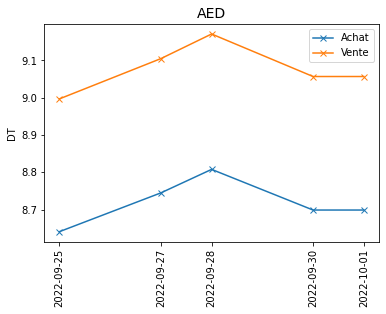

None


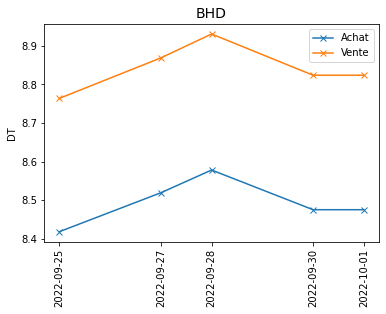

None


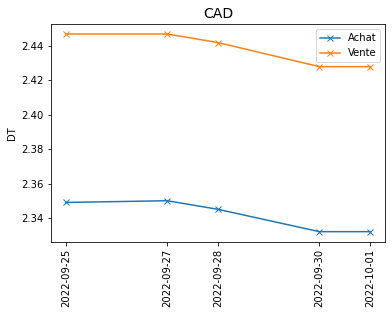

None


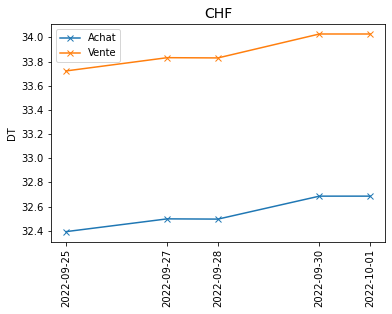

None


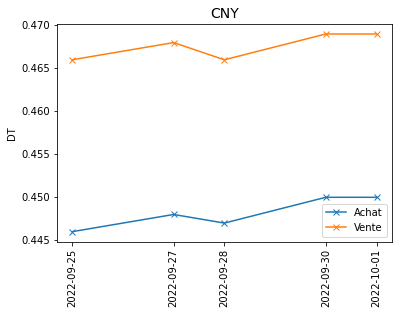

None


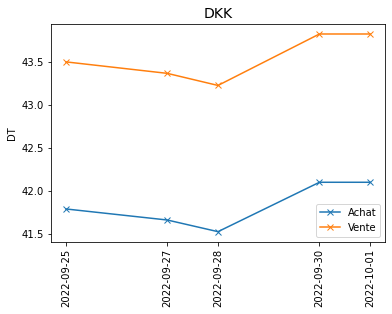

None


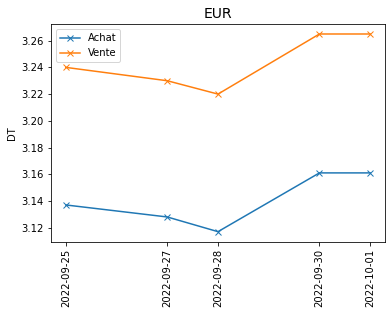

None


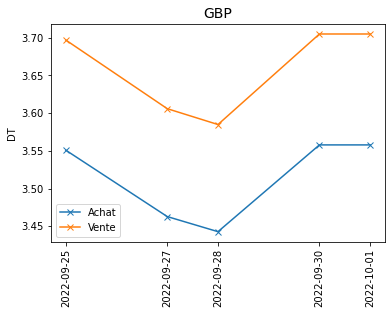

None


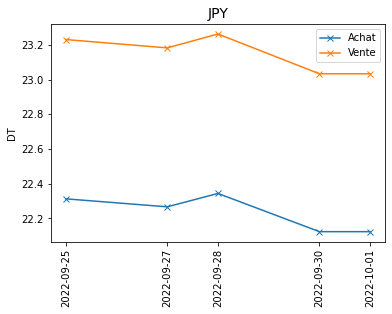

None


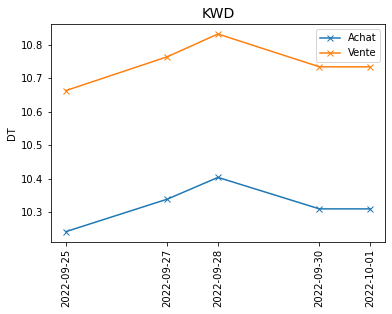

None


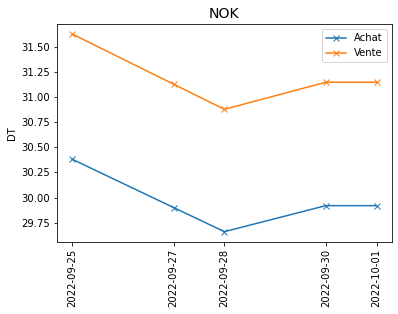

None


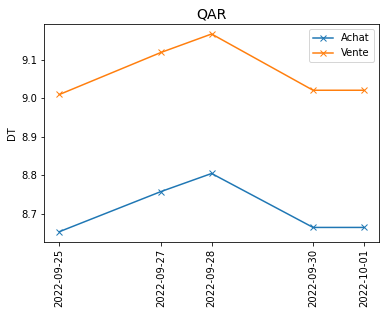

None


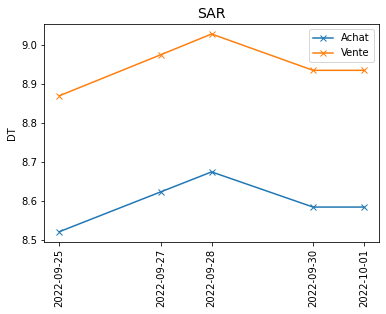

None


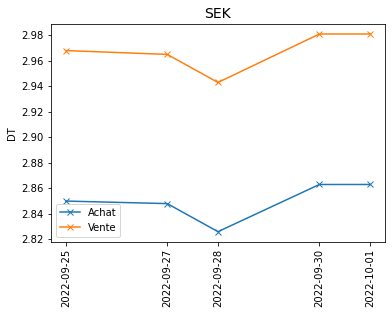

None


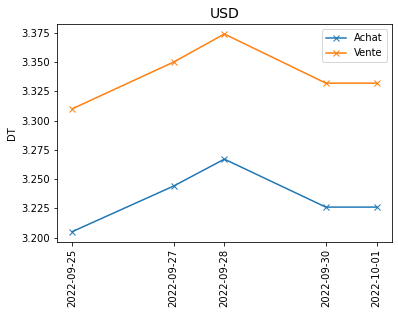

None


In [ ]:
# main program 

url = 'https://www.biat.tn/biat/Fr/cours-de-change_66_127'
db= open_database()
create_table(db)
for a in range(1):
    table_content= extract_currency_table(url)
    data=extract_currency_data(table_content)
    df = pd.DataFrame(data)
    insert_data (db,df)
    
    nb_rows = row_per_currency()
    Code_index=0
    for i in range(15):
        print(animate(DB_to_dataframe(),Code_index,nb_rows))
        Code_index= nb_rows
        nb_rows= nb_rows + row_per_currency()
        
    #define the amount of time you want your program to sleep (in seconds), here 60*60*24 = 24H 
    time.sleep(60*60*24)
db.close()